In [2]:
# Useful starting lines
%matplotlib inline
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Cross-Validation and Bias-Variance decomposition
## Cross-Validation
Implementing 4-fold cross-validation below:

In [3]:
from helpers import load_data

# load dataset
x, y = load_data()

(50,)

In [5]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [7]:
print(y.shape, (lambda x: x[0] * x[1])(build_k_indices(y, 11, 1).shape))

(50,) 44


In [10]:
from costs import compute_mse
from ridge_regression import ridge_regression
from build_polynomial import build_poly

def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""

    # building polynomial matrix for whole dataset
    x_poly = build_poly(x, degree)
    
    # indices for test
    idx_te = k_indices[k]
    
    # indices for train
    idx_tr = k_indices[np.arange(len(k_indices)) != k][0]
    
    # x data: train/test
    x_poly_tr = x_poly[idx_tr, :]
    x_poly_te = x_poly[idx_te, :]
    
    # y data: train/test
    y_tr = y[idx_tr]
    y_te = y[idx_te]
  
    # training ridge regression
    weights = ridge_regression(y_tr, x_poly_tr, lambda_)

    # computing losses
    loss_tr = compute_mse(y_tr, x_poly_tr, weights)
    loss_te = compute_mse(y_te, x_poly_te, weights)
    
    return loss_tr, loss_te

100%|██████████| 30/30 [00:00<00:00, 173.52it/s]


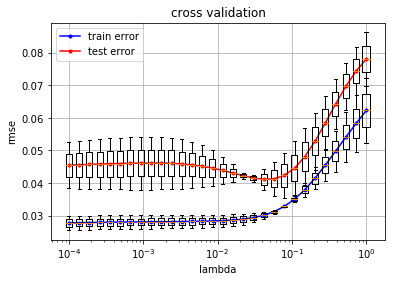

In [44]:
from plots import cross_validation_visualization

def cross_validation_demo():
    seed = 1
    degree = 7
    k_fold = 2
    lambdas = np.logspace(-4, 0, 30)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr, rmse_te = [], []
    rmse = [rmse_tr, rmse_te]
    rmse_all = [[], []]
    
    for lambda_ in tqdm(lambdas):
        rmse_ = [[], []]
        for k in range(k_fold):
            [rmse_[i].append(x) for i, x in
             enumerate(cross_validation(y, x, k_indices, k, lambda_, degree))]
        [rmse[i].append(np.mean(x)) for (i, x) in enumerate(rmse_)]
        [rmse_all[i].append(x) for (i, x) in enumerate(rmse_)]
    
    all_data = [np.array(rmse_all[0]).T, np.array(rmse_all[1]).T]
    
    cross_validation_visualization(lambdas, rmse_tr, rmse_te, all_data = all_data)

cross_validation_demo()

## Bias-Variance Decomposition
Visualize bias-variance trade-off by implementing the function `bias_variance_demo()` below:

In [ ]:
from least_squares import least_squares
from split_data import split_data
from plots import bias_variance_decomposition_visualization

def bias_variance_demo():
    """The entry."""
    # define parameters
    seeds = range(100)
    num_data = 10000
    ratio_train = 0.005
    degrees = range(1, 10)
    
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees)))
    rmse_te = np.empty((len(seeds), len(degrees)))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T
        # ***************************************************
        # INSERT YOUR CODE HERE
        # split data with a specific seed: TODO
        # ***************************************************
        raise NotImplementedError
        # ***************************************************
        # INSERT YOUR CODE HERE
        # bias_variance_decomposition: TODO
        # ***************************************************
        raise NotImplementedError

    bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te)

bias_variance_demo()